# Project Pizza
### Class w207, Todd Holloway
### Conner Brew, Maddie DiLullo Byrne, Joy Jiang, Peter Morgan

#### Loading Packages

In [1]:
%matplotlib inline

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

#### Loading Data

In [2]:
#load in training data. We will use this as both train and dev, and save 'test.json' for validation
data = pd.read_json('data/train/train.json').rename(columns = {'requester_received_pizza': 'target'})

#Change the boolean target variable to an int
data['target'] = data['target'].astype(int)

In [3]:
#Load in testing data and remove extra columns in data set that are not available in test data except for "target" (originally: requester_received_pizza)
data_test = pd.read_json('data/test/test.json')
data = data[data_test.columns.insert(0,'target')]
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 18 columns):
target                                                4040 non-null int64
giver_username_if_known                               4040 non-null object
request_id                                            4040 non-null object
request_text_edit_aware                               4040 non-null object
request_title                                         4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_comments_in_raop_at_request       4040 non-null int64
requester_number_of_posts_at_request                  4040 non-null int64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_number_of_subreddits_at_request             4040 non-null int

,target,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,0,N/A,t3_l25d7,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,0.000000,0,0,0,0,0,[],0,0,nickylvst,1317852607,1317849007
1,0,N/A,t3_rcb83,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,0.000000,0,0,15,0,12,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,1332652424,1332648824
2,0,N/A,t3_lpu5j,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,0.000000,0,0,0,0,0,[],0,0,jacquibatman7,1319650094,1319646494
3,0,N/A,t3_mxvj3,"It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,0.000000,36,0,1,0,4,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,76,4on_the_floor,1322855434,1322855434
4,0,N/A,t3_1i6486,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,101.606505,140,2,14,0,11,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1733,Futuredogwalker,1373657691,1373654091


 #### Initial Metrics for Exploratory Elements

In [4]:
#Get a rough idea of target baseline
baseline = round(sum(data['target']) / len(data['target']), 2)
print(f'Roughly {int(baseline * 100)}% of requests receive pizza.')

Roughly 25% of requests receive pizza.


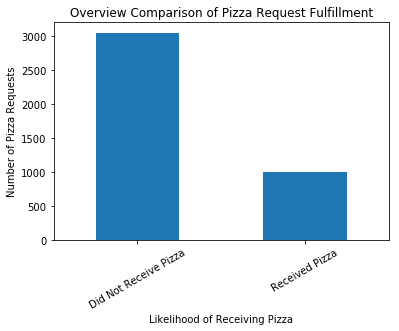

In [5]:
# Adding visual representation of the request received & ratio of those receiving pizza
plot = data['target'].value_counts(sort=False).plot.bar()
plt.xlabel("Likelihood of Receiving Pizza")
plt.ylabel("Number of Pizza Requests")
plt.title("Overview Comparison of Pizza Request Fulfillment")

labels = [item for item in plt.xticks()]
labels[0] = "Did Not Receive Pizza"
labels[1] = "Received Pizza"

plt.xticks([0, 1], ['Did Not Receive Pizza', 'Received Pizza'], rotation=30)


plt.show()

#### Random Forest Modeling & Validation

In [6]:
#The most basic possible model - extract only int variables, no transformations
int_data = data.select_dtypes(np.number)
y = int_data['target']
X = int_data.drop('target', axis=1)

#Default randomforest with cross validation
baseline_clf = RandomForestClassifier(max_depth=5, random_state=0)
scores = cross_val_score(baseline_clf, X, y, cv=5)

print(f'Baseline model accuracy without retrieval fields: {round(np.mean(scores), 2) * 100}%')

/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change fro

Baseline model accuracy without retrieval fields: 76.0%


In [7]:
data['request_date'] = data['unix_timestamp_of_request_utc'].apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
data['request_hour'] = data['unix_timestamp_of_request_utc'].apply(lambda x:datetime.utcfromtimestamp(x).strftime('%H')).astype(int)
data['weekday'] = data['request_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d').weekday())

data['up'] = ((data['requester_upvotes_plus_downvotes_at_request']+data['requester_upvotes_minus_downvotes_at_request'])/2).astype(int)
data['down'] = ((data['requester_upvotes_plus_downvotes_at_request']-data['requester_upvotes_minus_downvotes_at_request'])/2).astype(int)
data["up_pct"] = round(data['up']/data['requester_upvotes_plus_downvotes_at_request'],2).fillna(0)
data['first_timer'] = data['requester_subreddits_at_request'].apply(lambda x: 0 if ('Random_Acts_Of_Pizza' in x) else 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 25 columns):
target                                                4040 non-null int64
giver_username_if_known                               4040 non-null object
request_id                                            4040 non-null object
request_text_edit_aware                               4040 non-null object
request_title                                         4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_comments_in_raop_at_request       4040 non-null int64
requester_number_of_posts_at_request                  4040 non-null int64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_number_of_subreddits_at_request             4040 non-null int

Updated model accuracy: 76.0%


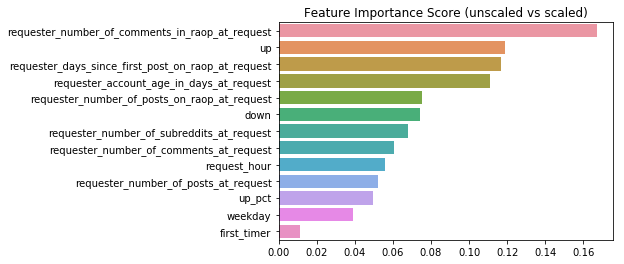

In [8]:
int_data = data.select_dtypes(np.number).drop(['unix_timestamp_of_request','unix_timestamp_of_request_utc','requester_upvotes_minus_downvotes_at_request','requester_upvotes_plus_downvotes_at_request'],axis=1)
y = int_data['target']
X = int_data.drop(['target'], axis=1)

#Updated randomforest 
clf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=5)
print(f'Updated model accuracy: {round(np.mean(scores), 2) * 100}%')

#Plot importance score
feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.title("Feature Importance Score (unscaled vs scaled)")
plt.show()

#### Looking at the data from a unigram logistic regression perspective

In [238]:
# Reformat subredddits from list of words to sentence 
data['requester_subreddits_at_request_text']=data['requester_subreddits_at_request'].apply(lambda x: " ".join(x))

# Dedicate 2/3rds of data to the training set, and 1/3rd to the dev set
twothirds = int(data.shape[0]*2/3)
train_data = data[:twothirds]['requester_subreddits_at_request_text']
train_labels = data[:twothirds]['target']
dev_data = data[twothirds:]['requester_subreddits_at_request_text']
dev_labels = data[twothirds:]['target']

#initializer vectorizer and transform training data into a matrix of word unigram feature vectors
vectorizer = CountVectorizer()
cv_train = vectorizer.fit_transform(train_data)
cv_dev = vectorizer.transform(dev_data)
features = np.array(vectorizer.get_feature_names())
print('number of features:',features.shape[0])

number of features: 6128


/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


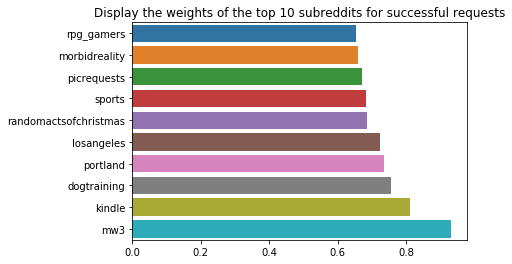

,unsuccessful
"(amisexy,)",0.861954
"(ama,)",0.807526
"(buildapc,)",0.767415
"(homeworkhelp,)",0.750311
"(xbox360,)",0.708153
"(soccer,)",0.695155
"(dubstep,)",0.682753
"(battlestations,)",0.676347
"(announcements,)",0.665403
"(shittyaskscience,)",0.640818


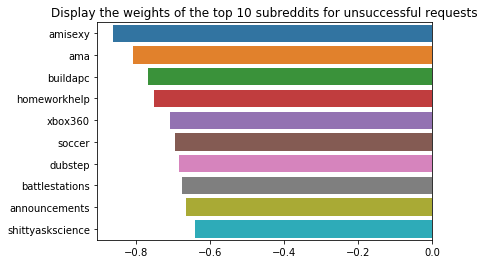

Actual from train data: Only 674 out of 2693 successfully get pizza (25.03% success rate).
Predicted from dev data: Only 74 out of 1347 successfully get pizza (5.49% success rate).


In [240]:
#build logistic regression model and use transformed train data to train the model
model = LogisticRegression(C=0.5, multi_class = 'ovr')
model.fit(cv_train, train_labels)

#find the top 5 features (by weight/coefficient) for successful request
top_coef_success = model.coef_.argsort(axis=1)[:,-10:]
top_features_success = features[top_coef_success]
top_weights_success = model.coef_[:,top_coef_success.flatten()]
df_success = pd.DataFrame(top_weights_success.T,index = top_features_success.T,columns=['success']).sort_values(by='success', ascending=False)
sns.barplot(x=list(top_weights_success.flatten()), y=list(top_features_success.flatten()))
plt.title("Display the weights of the top 10 subreddits for successful requests")
plt.show()

#find the top 5 features (by weight/coefficient) for unsuccessful request
features = np.array(vectorizer.get_feature_names())
top_coef_fail = model.coef_.argsort(axis=1)[:,:10]
top_features_fail = features[top_coef_fail]
top_weights_fail = model.coef_[:,top_coef_fail.flatten()]
display(pd.DataFrame(-top_weights_fail.T,index = top_features_fail.T,columns=['unsuccessful']))
sns.barplot(x=list(top_weights_fail.flatten()), y=list(top_features_fail.flatten()))
plt.title("Display the weights of the top 10 subreddits for unsuccessful requests")
plt.show()

#comparing success rate from train data vs the predicted success rate from subreddits classifier model 
success_rate = round(sum(train_labels) / len(train_labels) * 100,2)
print(str('Actual from train data: Only {} out of {} successfully get pizza ({}% success rate).'.format(sum(train_labels), len(train_labels), success_rate)))

dev_pred = model.predict(cv_dev)
success_rate = round(sum(dev_pred) / len(dev_pred) * 100,2)
print(str('Predicted from dev data: Only {} out of {} successfully get pizza ({}% success rate).'.format(sum(dev_pred), len(dev_pred), success_rate)))


In [ ]:
# explore options to incorporate 
# future development: model can be enhanced if mapping of category exists for different subreddits (too many )

In [10]:
# Load Train Data
train_data = data['request_title']
train_labels = data['target']
# I decided to dedicate 2/3rds to the training set, and 1/3rd to the dev set
twothirds = int(train_data.shape[0]*2/3)
# Splitting into the training & dev sets
dev_data = train_data[twothirds:]
dev_labels = train_labels[twothirds:]

train_data = train_data[:twothirds]
train_labels = train_labels[:twothirds]

# Transforming data into unigram matrix
vector = CountVectorizer(analyzer = "word", ngram_range=(2,3)) #Using a flexible range ngram to allow for common phrases that occur in requests
matrix = vector.fit_transform(train_data)
# Performing the logistic regression on the training data   
log_reg = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
log_reg.fit(matrix, train_labels)
# Calculating the weights for the top 10 heaviest weights 
weights = log_reg.coef_
heaviest_10 = (-weights).argsort(axis=1)[:,:10].flatten()
# Finding the features associated to the top 10 heaviest weights
features = [vector.get_feature_names()[weight] for weight in heaviest_10]

[vector.get_feature_names()[weight] for weight in heaviest_10]
for i in features:
    dataframe = pd.DataFrame(index = features)

            
display(dataframe)


""
request broke until
sad story
chicago il
request college
for broke
for our
college girl
my dog
to get
request ve


In [201]:
# Load Train Data
train_data = data['request_text']
train_labels = data['target']
# I decided to dedicate 2/3rds to the training set, and 1/3rd to the dev set
twothirds = int(train_data.shape[0]*2/3)
# Splitting into the training & dev sets
dev_data = train_data[twothirds:]
dev_labels = train_labels[twothirds:]

train_data = train_data[:twothirds]
train_labels = train_labels[:twothirds]


# Transforming data into unigram matrix
vector = CountVectorizer(analyzer = "word") #Using a flexible range ngram to allow for common phrases that occur in requests
matrix = vector.fit_transform(train_data)
# Performing the logistic regression on the training data   
log_reg = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
log_reg.fit(matrix, train_labels)
# Calculating the weights for the top 10 heaviest weights 
weights = log_reg.coef_
heaviest_10 = (-weights).argsort(axis=1)[:,:10].flatten()
# Finding the features associated to the top 10 heaviest weights
features = [vector.get_feature_names()[weight] for weight in heaviest_10]

[vector.get_feature_names()[weight] for weight in heaviest_10]
for i in features:
    dataframe = pd.DataFrame(index = features)

            
display(dataframe)


KeyError: 'request_text'

### Other elements to explore:
- Some more exploratory analysis on numeric data present (i.e. normalization of the data) & being able to customize metrics that could also have an impact (average upvotes over duration from retrieval).
- Parsing out the logistic regression of the unigram modeling to see if there are specific phrases that lead to more success/failure of receiving pizza